# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2024 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [6]:
year = "2024"
years = [2024]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 192748


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [9]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
32827,20240312185445PD,9933915,3/12/2024 12:00:00 AM,P240720771,2,3/12/2024 12:00:00 AM,3/12/2024 12:00:00 AM,18:15:03,WELCK,WELFARE CHECK,N,No report required; dispatch record only,STEVENS CREEK BL & SARATOGA AV,San Jose,CA,37.317539,-121.974537,Cypress
138747,20240702162429PD,10074675,7/2/2024 12:00:00 AM,P241840448,6,7/2/2024 12:00:00 AM,7/2/2024 12:00:00 AM,12:36:46,1195X,VEHICLE STOP ON FEMALE,D,"Traffic Citation Issued, Hazardous Violation",ENESCO AV & OTHELLO AV,San Jose,CA,37.316900,-121.819481,Meadow Fair
150981,20240721141136PD,10100049,7/21/2024 12:00:00 AM,P242030338,3,7/21/2024 12:00:00 AM,7/21/2024 12:00:00 AM,11:19:21,602PC,TRESPASSING,A,Arrest Made,[1800]-[1900] E CAPITOL EX,San Jose,CA,NaN,NaN,NaN
91703,20240529110704PD,10030785,5/29/2024 12:00:00 AM,P241500326,2,5/29/2024 12:00:00 AM,5/29/2024 12:00:00 AM,10:52:27,415,DISTURBANCE,N,No report required; dispatch record only,[2000]-[2100] AIRPORT BL,San Jose,CA,NaN,NaN,NaN
28439,20240307200419PS,9927582,3/7/2024 12:00:00 AM,P240670916,2,3/7/2024 12:00:00 AM,3/7/2024 12:00:00 AM,19:56:45,415A,"DISTURBANCE, FIGHT",CAN,Canceled,[400]-[400] SANDS DR,San Jose,CA,37.288607,-121.872277,Canoas Garden and Almaden


In [11]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192748 entries, 0 to 192747
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              192748 non-null  object 
 1   EID               192748 non-null  int64  
 2   START_DATE        192748 non-null  object 
 3   CALL_NUMBER       192748 non-null  object 
 4   PRIORITY          192748 non-null  int64  
 5   REPORT_DATE       192748 non-null  object 
 6   OFFENSE_DATE      192748 non-null  object 
 7   OFFENSE_TIME      192748 non-null  object 
 8   CALLTYPE_CODE     192748 non-null  object 
 9   CALL_TYPE         192748 non-null  object 
 10  FINAL_DISPO_CODE  192748 non-null  object 
 11  FINAL_DISPO       192748 non-null  object 
 12  ADDRESS           187429 non-null  object 
 13  CITY              192748 non-null  object 
 14  STATE             192748 non-null  object 
 15  LATITUDE          172999 non-null  float64
 16  LONGITUDE         17

In [13]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,1.927480e+05,192748.000000,172999.000000,172999.000000
mean,1.000512e+07,3.195649,37.321599,-121.872628
std,9.205661e+04,1.339486,0.042898,0.047654
min,9.844603e+06,1.000000,37.158193,-122.035696
25%,9.925863e+06,2.000000,37.296972,-121.904114
50%,1.000579e+07,3.000000,37.324756,-121.870477
75%,1.008432e+07,4.000000,37.349473,-121.840429
max,1.016501e+07,8.000000,37.534539,-121.684849


In [15]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,192748,192748,192748,192748,192748,192748,192748,192748,192748,192748,187429,192748,192748,172218
unique,191692,215,189178,253,253,78425,205,199,23,18,25237,1,1,295
top,20240608212233PD,6/12/2024 12:00:00 AM,P241480648,2/4/2024 12:00:00 AM,2/4/2024 12:00:00 AM,14:06:22,415,DISTURBANCE,N,No report required; dispatch record only,[2800]-[2900] STEVENS CREEK BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,21199,7,1118,1118,12,17973,17973,87230,87230,1196,192748,192748,5399


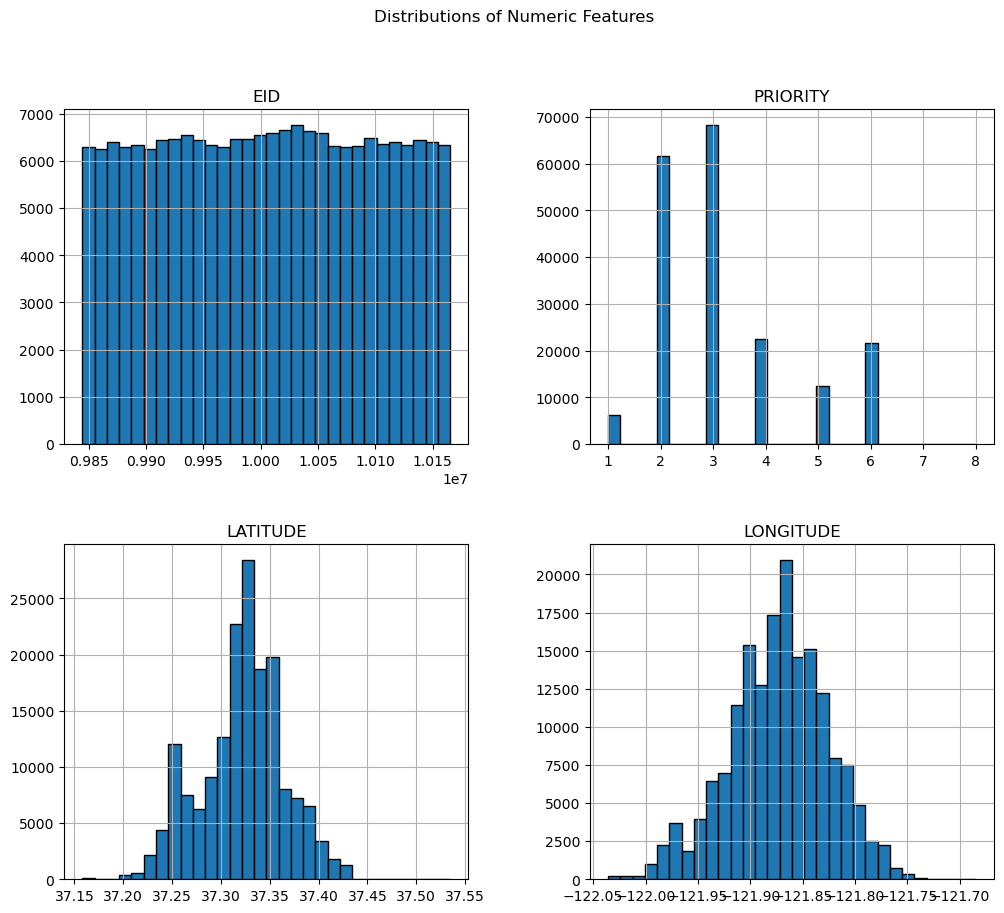

In [17]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [18]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              5319
CITY                    0
STATE                   0
LATITUDE            19749
LONGITUDE           19749
neighborhood        20530
dtype: int64

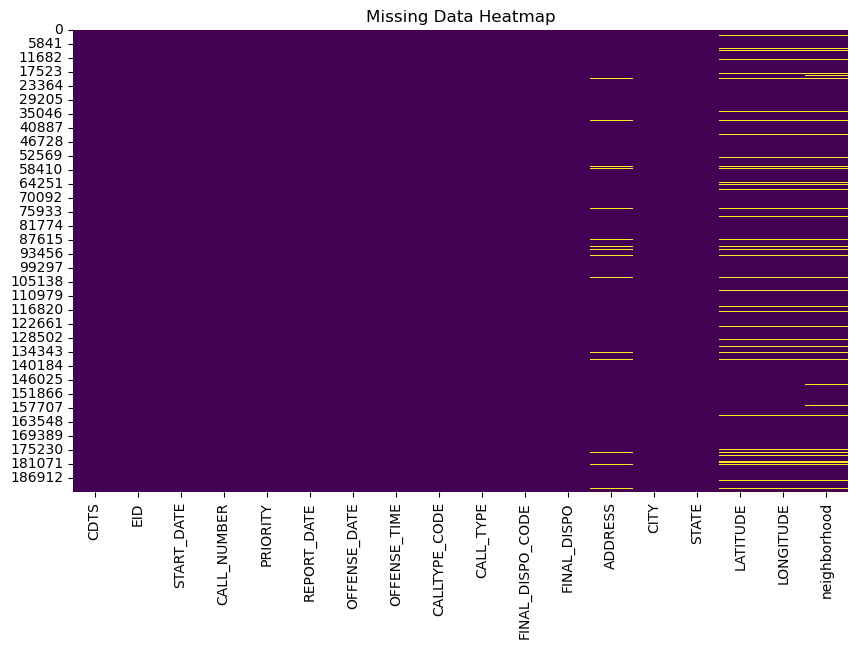

In [21]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [22]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 191692 unique values
START_DATE: 215 unique values
CALL_NUMBER: 189178 unique values
REPORT_DATE: 253 unique values
OFFENSE_DATE: 253 unique values
OFFENSE_TIME: 78425 unique values
CALLTYPE_CODE: 205 unique values
CALL_TYPE: 199 unique values
FINAL_DISPO_CODE: 23 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 25237 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [23]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      5399
Little Saigon and Spring Brook    3299
Trimble Business Area             2998
Steinbeck and Allen               2688
O'Connor Park                     2662
                                  ... 
Meadowlands                         25
Los Alamitos Creek                  22
Linda Vista and Hillcrest           21
Santa Teresa Hills                  17
Alta Vista                           9
Name: count, Length: 295, dtype: int64

In [24]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          87230
CAN        40536
R          24311
G           8775
O           3679
DUPNCAN     3468
A           3457
E           3126
D           3110
GD          2764
U           2615
H           2243
T           2165
C           1508
ADV         1359
B           1173
NR           673
F            464
Z             38
P             34
M             17
TOT            2
DUP            1
Name: count, dtype: int64

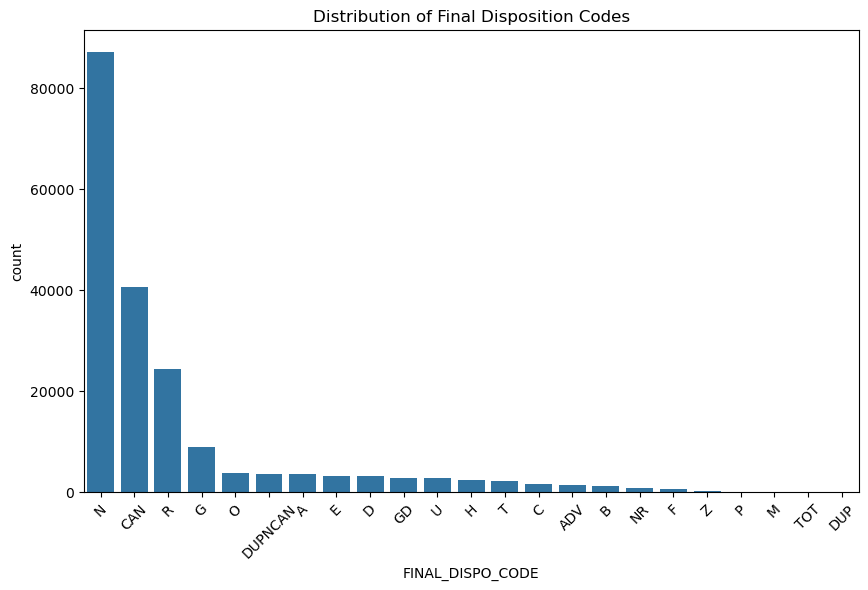

In [29]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [31]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            87230
Canceled                                            40536
Report taken                                        24311
Gone on Arrival/unable to locate                     8775
No Disposition                                       7632
Supplemental report taken                            3679
Arrest Made                                          3457
Traffic Citation Issued, Non-Hazardous Violation     3126
Traffic Citation Issued, Hazardous Violation         3110
Unfounded event                                      2615
Courtesy Service/Citizen or agency assist            2243
Turned over To (TOT)                                 2165
Criminal Citation                                    1508
Arrest by Warrant                                    1173
No Response                                           673
Field Interview (F.I.) Completed                      464
Prior case, follow-up activity only                    34
St

In [33]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch record only',
 'DUPNCAN': 'No Disposition',
 'G': 'Gone on Arrival/unable to locate',
 'CAN': 'Canceled',
 'ADV': 'No Disposition',
 'R': 'Report taken',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'NR': 'No Response',
 'GD': 'No Disposition',
 'A': 'Arrest Made',
 'C': 'Criminal Citation',
 'U': 'Unfounded event',
 'H': 'Courtesy Service/Citizen or agency assist',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'B': 'Arrest by Warrant',
 'F': 'Field Interview (F.I.) Completed',
 'P': 'Prior case, follow-up activity only',
 'M': 'Stranded motorist assist',
 'Z': 'No Disposition',
 'TOT': 'No Disposition',
 'DUP': 'No Disposition'}

In [35]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1154': 'SUSPICIOUS VEHICLE',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 'WELCK': 'WELFARE CHECK',
 '22500': 'PARKING VIOLATION',
 '10851': 'STOLEN VEHICLE',
 '415': 'DISTURBANCE',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 '1033A': 'ALARM, AUDIBLE',
 '12025': 'CARRYING A CONCEALED WEAPON',
 '911UNK': 'UNK TYPE 911 CALL',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '6F': 'FELONY WANT',
 '1195': 'VEHICLE STOP',
 '1091': 'ANIMAL COMPLAINT',
 '5150X': 'MENTALLY DISTURBED FEMALE',
 '1066': 'SUSPICIOUS PERSON',
 '415F': 'DISTURBANCE, FAMILY',
 '415M': 'DISTURBANCE, MUSIC',
 '1057': 'FIREARMS DISCHARGED',
 '602PC': 'TRESPASSING',
 '10851R': 'RECOVERED STOLEN VEHICLE',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '5150': 'MENTALLY DISTURBED PERSON',
 '415W': 'DISTURBANCE, WEAPON',
 '23103': 'RECKLESS DRIVING',
 '594': 'MALICIOUS MISCHIEF',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 'FNDPRP': 'FOUND PROPERTY',
 '1065': 'MISSING PERSON',
 '415FC': 'DISTURBANCE,

## Focus on Target Dispositions

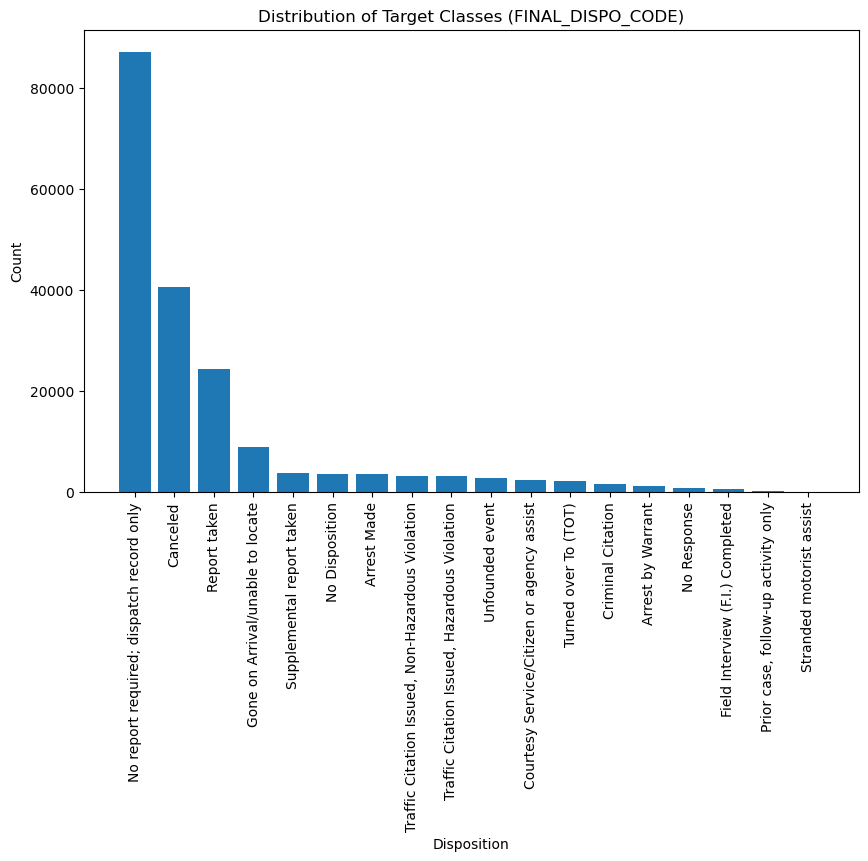

In [38]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [40]:
model_utils.transform_offense_date(all_police_df)

In [42]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    186610
A          3457
C          1508
B          1173
Name: count, dtype: int64

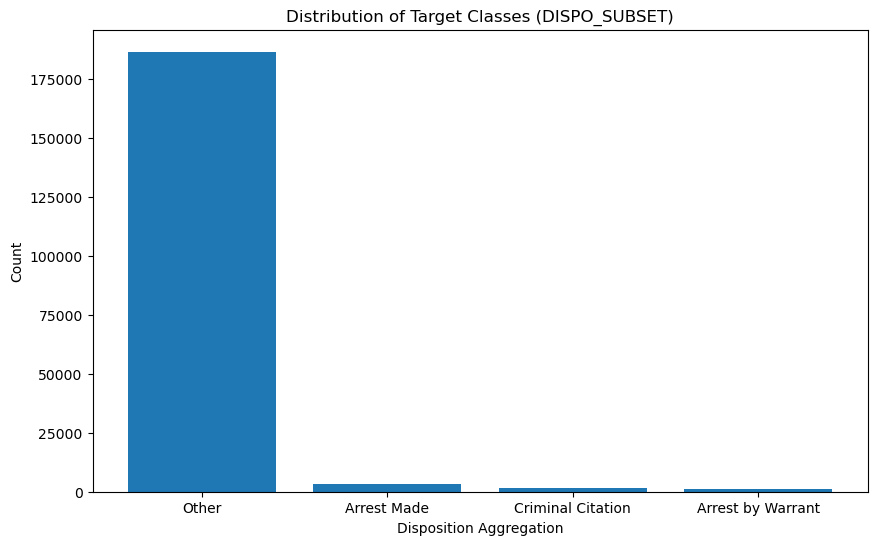

In [44]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [47]:
encoder = joblib.load('one_hot_encoder.pkl')

In [49]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 192748 rows before cleaning, 172218 rows after cleaning.


(172218, 535)

## Define X and Y

In [51]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(137774, 534)
(34444, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 133309, 0: 2519, 2: 1083, 1: 863})
Counter({3: 4465, 0: 2519, 2: 1083, 1: 863})


y_train distribution: Counter({3: 133309, 0: 2519, 2: 1083, 1: 863})
y_test distribution: Counter({3: 33328, 0: 629, 2: 271, 1: 216})
y_train_resampled distribution: Counter({3: 133309, 0: 2519, 2: 1083, 1: 863})


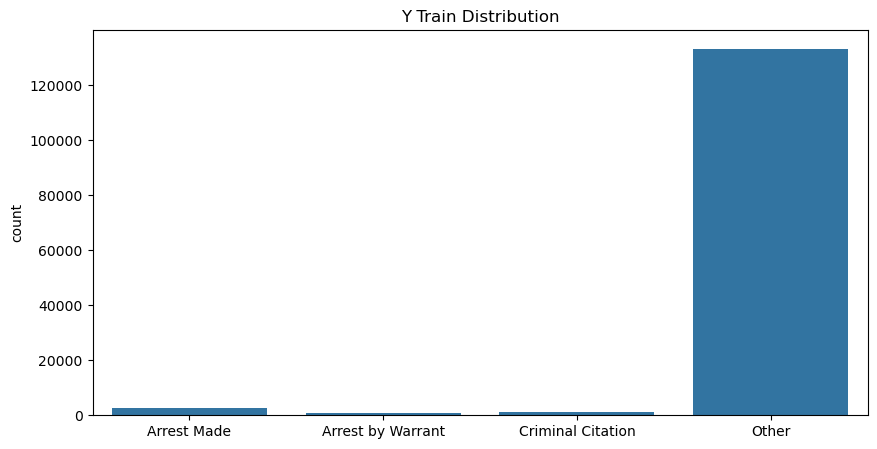

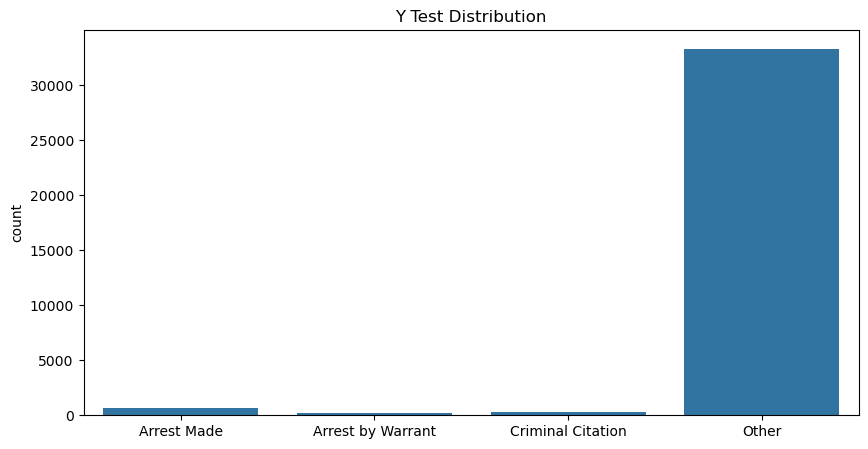

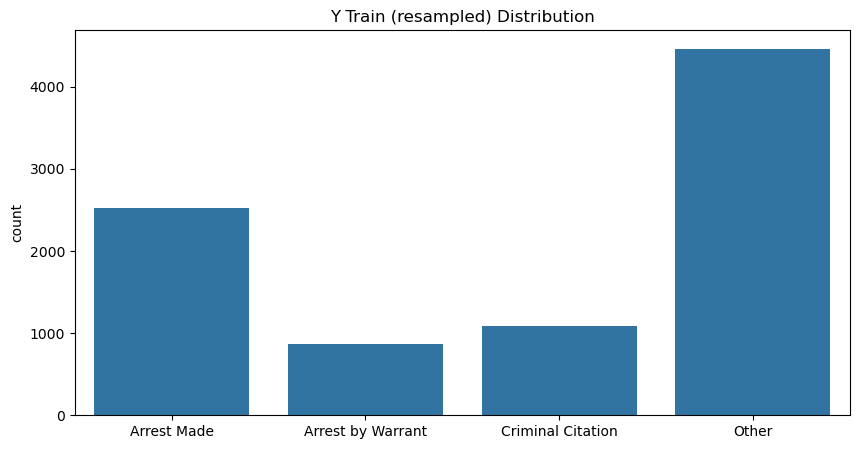

In [53]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [57]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [60]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [62]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       629
Arrest by Warrant       0.00      0.00      0.00       216
Criminal Citation       0.00      0.00      0.00       271
            Other       0.97      1.00      0.98     33328

         accuracy                           0.97     34444
        macro avg       0.24      0.25      0.25     34444
     weighted avg       0.94      0.97      0.95     34444



### Logistic Regression

In [65]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [66]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [67]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.11      0.58      0.18       629
Arrest by Warrant       0.27      0.43      0.33       216
Criminal Citation       0.10      0.55      0.17       271
            Other       0.99      0.87      0.92     33328

         accuracy                           0.86     34444
        macro avg       0.37      0.61      0.40     34444
     weighted avg       0.96      0.86      0.90     34444



#### Hyperparameter Tuning

In [69]:
grid_search_scoring_method = 'f1_macro'

In [70]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [71]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.4757


In [72]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2024/best_logistic_regression.pkl']

In [73]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [77]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.21      0.31       629
Arrest by Warrant       0.59      0.42      0.49       216
Criminal Citation       0.39      0.09      0.15       271
            Other       0.98      1.00      0.99     33328

         accuracy                           0.97     34444
        macro avg       0.63      0.43      0.48     34444
     weighted avg       0.96      0.97      0.96     34444



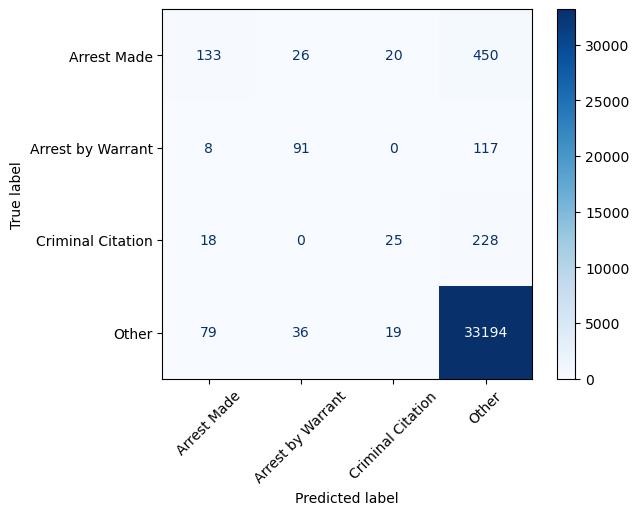

In [79]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [81]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [82]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [83]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                     Feature  Importance  \
204                         CALLTYPE_CODE_6F    0.003049   
112                      CALLTYPE_CODE_23152    0.002710   
205                         CALLTYPE_CODE_6M    0.002178   
58                        CALLTYPE_CODE_1095    0.001936   
170                        CALLTYPE_CODE_484    0.001694   
64                       CALLTYPE_CODE_11300    0.001645   
49                      CALLTYPE_CODE_10851R    0.001113   
80                        CALLTYPE_CODE_1195    0.001065   
119                        CALLTYPE_CODE_242    0.000968   
125                        CALLTYPE_CODE_245    0.000774   
479         neighborhood_Steinbeck and Allen    0.000774   
113                      CALLTYPE_CODE_23153    0.000726   
193                      CALLTYPE_CODE_602PC    0.000726   
162                        CALLTYPE_CODE_422    0.000678   
146                       CALLTYPE_CODE_415F    0.000678   
141                        CALLTYPE_CODE

In [84]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                        Display Name  Coefficient
13                         Call Type: ALARM, AUDIBLE    -0.453339
107                     Call Type: PARKING VIOLATION    -0.443647
153                    Call Type: DISTURBANCE, MUSIC    -0.384904
212                     Call Type: UNK TYPE 911 CALL    -0.334845
49               Call Type: RECOVERED STOLEN VEHICLE     0.310756
47                         Call Type: STOLEN VEHICLE     0.268298
63                         Call Type: TRAFFIC HAZARD    -0.246717
231         Call Type: VIOLATION OF PROTECTIVE ORDER     0.238512
112                       Call Type: MISDEMEANOR DUI     0.224883
146                   Call Type: DISTURBANCE, FAMILY     0.212102
16                          Call Type: ALARM, SILENT    -0.207264
9                                         LATITUDE^2    -0.205731
103                    Call Type: STRONG ARM ROBBERY     0.194460
94                     Call Type: FELONY HIT AND RUN   

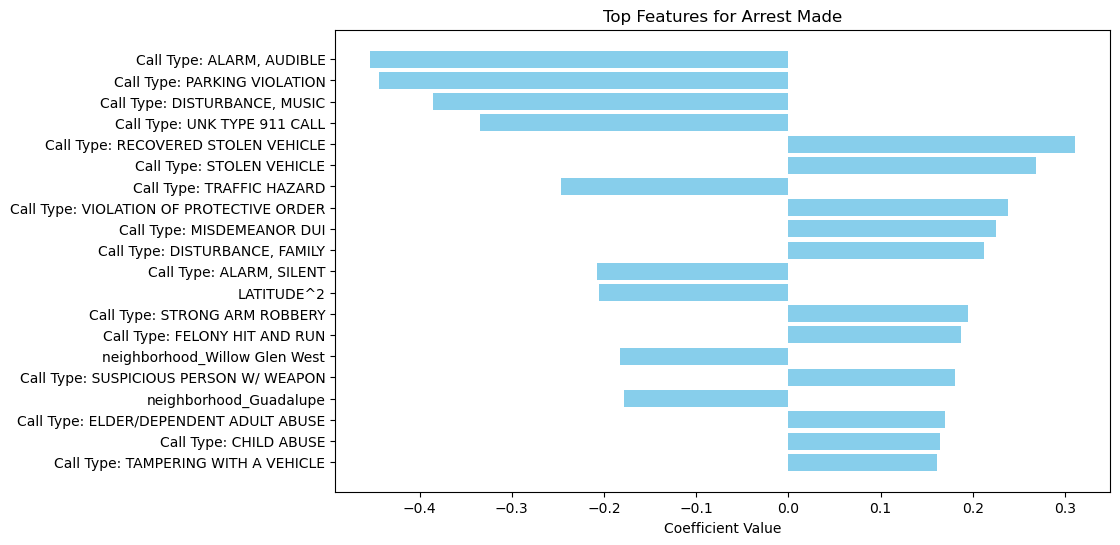

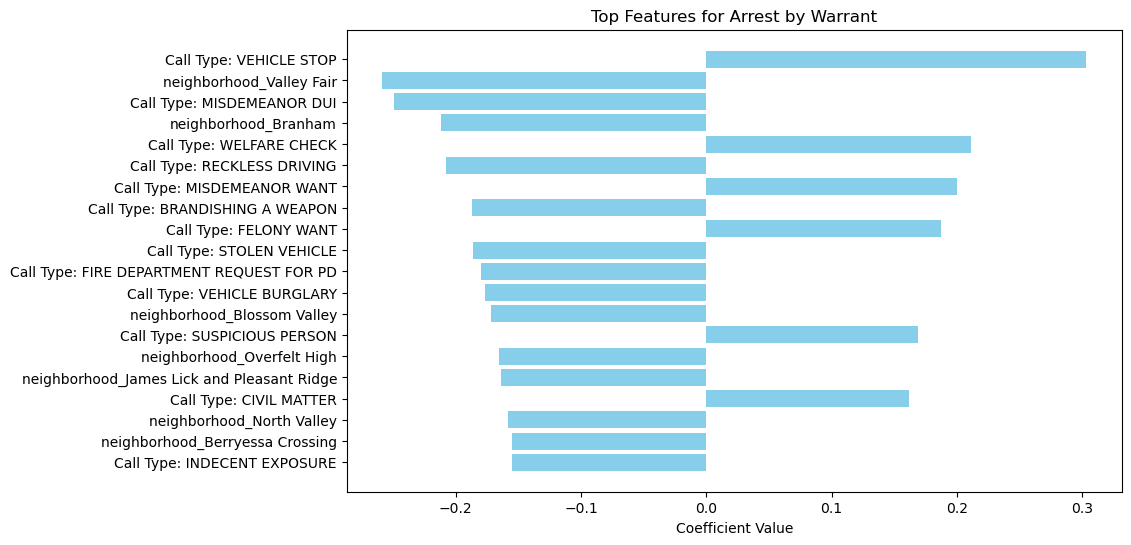

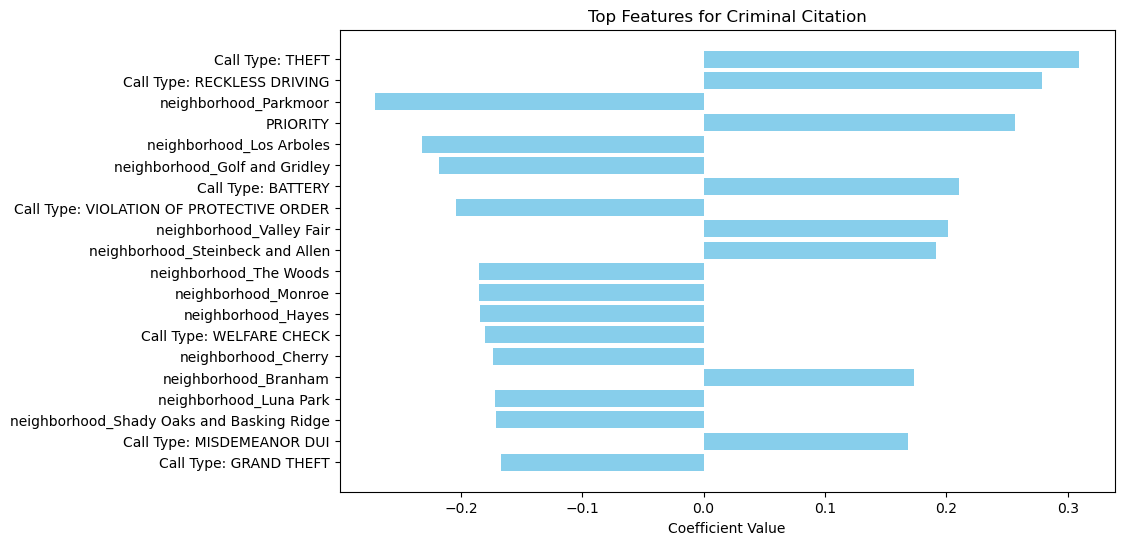

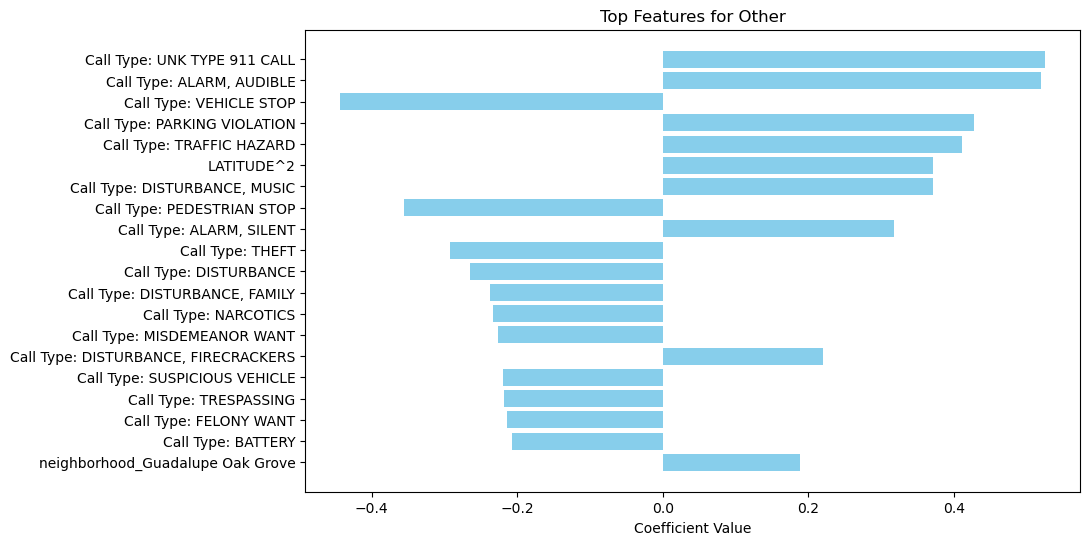

In [85]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [87]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [88]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.47      0.20      0.28       629
Arrest by Warrant       0.50      0.35      0.41       216
Criminal Citation       0.30      0.16      0.21       271
            Other       0.98      0.99      0.98     33328

         accuracy                           0.97     34444
        macro avg       0.56      0.43      0.47     34444
     weighted avg       0.96      0.97      0.96     34444



#### Hyperparameter Tuning and Cross Validation

In [90]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.47


In [91]:
best_rf = grid_rf.best_estimator_

In [92]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2024/best_random_forest.pkl']

In [93]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [94]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.48      0.20      0.29       629
Arrest by Warrant       0.51      0.35      0.42       216
Criminal Citation       0.26      0.13      0.18       271
            Other       0.98      0.99      0.98     33328

         accuracy                           0.97     34444
        macro avg       0.56      0.42      0.47     34444
     weighted avg       0.96      0.97      0.96     34444



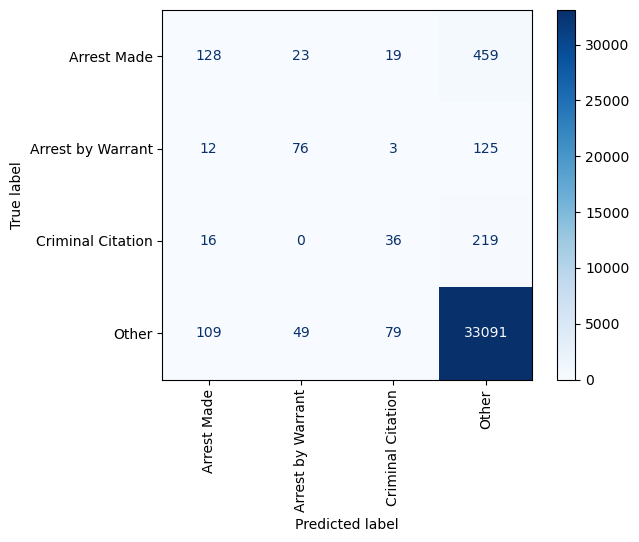

In [95]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

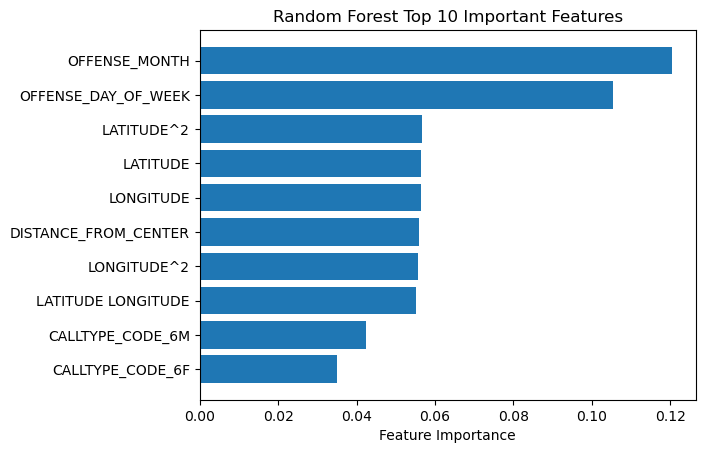

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [99]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [100]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [101]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [102]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9644 - loss: 0.1860 - val_accuracy: 0.9715 - val_loss: 0.1129
Epoch 2/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9693 - loss: 0.1257 - val_accuracy: 0.9718 - val_loss: 0.1132
Epoch 3/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9698 - loss: 0.1184 - val_accuracy: 0.9714 - val_loss: 0.1138
Epoch 4/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9693 - loss: 0.1166 - val_accuracy: 0.9707 - val_loss: 0.1121
Epoch 5/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9705 - loss: 0.1112 - val_accuracy: 0.9720 - val_loss: 0.1152
Epoch 6/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9700 - loss: 0.1097 - val_accuracy: 0.9725 - val_loss: 0.1170
Epoch 7/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9704 - loss: 0.1059 - val_accuracy: 0.9720 - val_loss: 0.1182
Epoch 8/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9713 - loss: 0.1025 - 

In [103]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2024/mlp_model.pkl']

In [104]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [105]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.9699 - loss: 0.1208
Test Accuracy: 0.9689


In [106]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.33      0.02      0.04       629
Arrest by Warrant       0.62      0.32      0.42       216
Criminal Citation       0.00      0.00      0.00       271
            Other       0.97      1.00      0.98     33328

         accuracy                           0.97     34444
        macro avg       0.48      0.34      0.36     34444
     weighted avg       0.95      0.97      0.96     34444



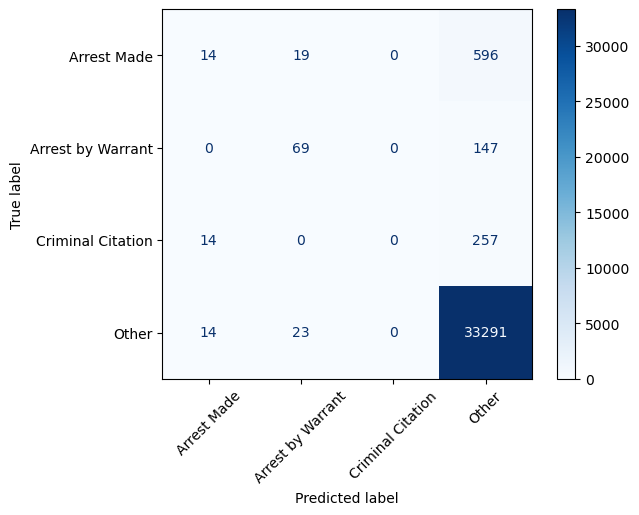

In [107]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [110]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 14:15:21,859] A new study created in memory with name: no-name-7090becd-27fa-49fe-9680-2b45604ca988
[I 2024-10-04 14:15:43,131] Trial 0 finished with value: 0.5657884778802078 and parameters: {'n_estimators': 401, 'learning_rate': 0.002210032868703943, 'max_depth': 4, 'subsample': 0.9023575710066154, 'colsample_bytree': 0.7329494723191637, 'gamma': 7.081663021837892e-06, 'reg_alpha': 7.801298376501644e-07, 'reg_lambda': 4.7887773935342977e-08}. Best is trial 0 with value: 0.5657884778802078.
[I 2024-10-04 14:15:58,130] Trial 1 finished with value: 0.6174167111522515 and parameters: {'n_estimators': 137, 'learning_rate': 0.04725806625216261, 'max_depth': 12, 'subsample': 0.6121315097994362, 'colsample_bytree': 0.7230075727529266, 'gamma': 5.623562491361823e-08, 'reg_alpha': 3.306997384869968e-06, 'reg_lambda': 0.6105526302385453}. Best is trial 1 with value: 0.6174167111522515.
[I 2024-10-04 14:16:09,159] Trial 2 finished with value: 0.6228315946045578 and parameters: {'n_

Actual runtime: 341.48 seconds (5.69 minutes)
Best parameters found:  {'n_estimators': 330, 'learning_rate': 0.10214218090689126, 'max_depth': 5, 'subsample': 0.9791418502460765, 'colsample_bytree': 0.6656149693067726, 'gamma': 3.881732801550862e-06, 'reg_alpha': 1.2756699916030553e-07, 'reg_lambda': 8.156273375645176e-06}
Best F1 macro score:  0.6333513056394462


In [111]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6656149693067726, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=3.881732801550862e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10214218090689126, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=330, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [112]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.19      0.29       629
Arrest by Warrant       0.56      0.36      0.44       216
Criminal Citation       0.42      0.10      0.17       271
            Other       0.98      1.00      0.99     33328

         accuracy                           0.97     34444
        macro avg       0.63      0.41      0.47     34444
     weighted avg       0.96      0.97      0.96     34444



In [113]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2024/xgb_model.pkl']

In [114]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [116]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [117]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.4838708403111301
RF F1: 0.4662338369637128
XGB F1: 0.4705026117597559


In [118]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [120]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6656149693067726,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                              learning_rate=0.10214218090689126,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=330, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [121]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2024/stacking_1.pkl']

In [122]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [123]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.48377613079059084


#### Stacking #2

In [125]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6656149693067726,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [126]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2024/stacking_2.pkl']

In [127]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [128]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.4833802698380216


## Results

In [130]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.967600,0.250000,0.241900,0.245883
Logistic Regression,0.970938,0.430243,0.630207,0.483871
Random Forest,0.967687,0.420270,0.558904,0.466234
MLP,0.968935,0.335148,0.481448,0.362103
XGB,0.970619,0.413668,0.634844,0.470503
Stack 1,0.970735,0.422577,0.628216,0.483776
Stack 2,0.970213,0.427142,0.621696,0.483380


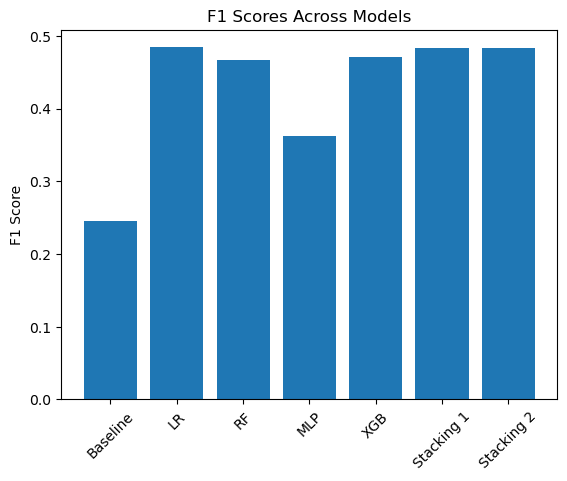

In [131]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [133]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [134]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

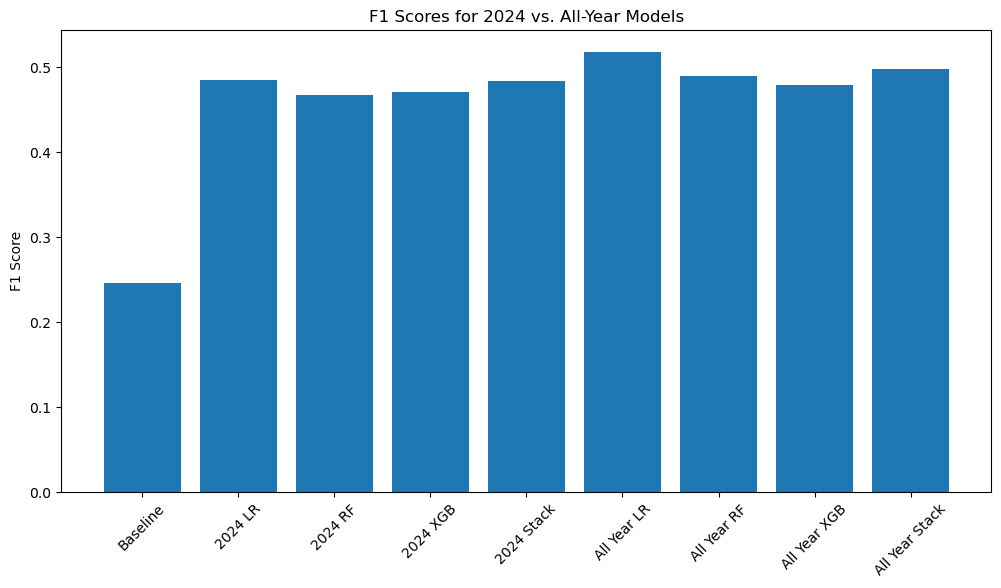

In [135]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()